# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8529
Epoch 1/200, Iteration 2/12, Loss: 0.6435
Epoch 1/200, Iteration 3/12, Loss: 1.6057
Epoch 1/200, Iteration 4/12, Loss: 1.1538
Epoch 1/200, Iteration 5/12, Loss: 0.6474
Epoch 1/200, Iteration 6/12, Loss: 0.4231
Epoch 1/200, Iteration 7/12, Loss: 0.4317
Epoch 1/200, Iteration 8/12, Loss: 0.4540
Epoch 1/200, Iteration 9/12, Loss: 0.3858
Epoch 1/200, Iteration 10/12, Loss: 0.4314
Epoch 1/200, Iteration 11/12, Loss: 0.4573
Epoch 1/200, Iteration 12/12, Loss: 0.2948
Epoch 1/200, Iteration 13/12, Loss: 0.2907
Train Error: 
 Accuracy: 57.5%, Avg loss: 0.297742, MRE: 0.272882, MAE: 0.040655 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.275575, MRE: 0.209223, MAE: 0.038363 

Epoch 2/200, Iteration 1/12, Loss: 0.2995
Epoch 2/200, Iteration 2/12, Loss: 0.2518
Epoch 2/200, Iteration 3/12, Loss: 0.2931
Epoch 2/200, Iteration 4/12, Loss: 0.2346
Epoch 2/200, Iteration 5/12, Loss: 0.2595
Epoch 2/200, Iteration 6/12, Loss: 0.2495
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 97.25%, Avg loss: 0.099037, MRE: 0.071175, MAE: 0.012227 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.090298, MRE: 0.057639, MAE: 0.011278 

Epoch 13/200, Iteration 1/12, Loss: 0.0842
Epoch 13/200, Iteration 2/12, Loss: 0.1432
Epoch 13/200, Iteration 3/12, Loss: 0.1444
Epoch 13/200, Iteration 4/12, Loss: 0.1363
Epoch 13/200, Iteration 5/12, Loss: 0.1579
Epoch 13/200, Iteration 6/12, Loss: 0.1013
Epoch 13/200, Iteration 7/12, Loss: 0.1090
Epoch 13/200, Iteration 8/12, Loss: 0.1225
Epoch 13/200, Iteration 9/12, Loss: 0.1237
Epoch 13/200, Iteration 10/12, Loss: 0.1353
Epoch 13/200, Iteration 11/12, Loss: 0.1316
Epoch 13/200, Iteration 12/12, Loss: 0.1214
Epoch 13/200, Iteration 13/12, Loss: 0.1484
Train Error: 
 Accuracy: 90.38%, Avg loss: 0.099339, MRE: 0.073980, MAE: 0.014528 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.109556, MRE: 0.070052, MAE: 0.015993 

Epoch 14/200, Iteration 1/12, Loss: 0.1088
Epoch 14/200, Iteration 2/12, Loss: 0.1470
Epoch 14/200, Itera

Train Error: 
 Accuracy: 81.38%, Avg loss: 0.132308, MRE: 0.076059, MAE: 0.020386 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.132797, MRE: 0.067875, MAE: 0.021099 

Epoch 25/200, Iteration 1/12, Loss: 0.1400
Epoch 25/200, Iteration 2/12, Loss: 0.1168
Epoch 25/200, Iteration 3/12, Loss: 0.1135
Epoch 25/200, Iteration 4/12, Loss: 0.1035
Epoch 25/200, Iteration 5/12, Loss: 0.0932
Epoch 25/200, Iteration 6/12, Loss: 0.1092
Epoch 25/200, Iteration 7/12, Loss: 0.1045
Epoch 25/200, Iteration 8/12, Loss: 0.1227
Epoch 25/200, Iteration 9/12, Loss: 0.1184
Epoch 25/200, Iteration 10/12, Loss: 0.1442
Epoch 25/200, Iteration 11/12, Loss: 0.1407
Epoch 25/200, Iteration 12/12, Loss: 0.1186
Epoch 25/200, Iteration 13/12, Loss: 0.1192
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.128788, MRE: 0.119102, MAE: 0.015430 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.123810, MRE: 0.106879, MAE: 0.014712 

Epoch 26/200, Iteration 1/12, Loss: 0.1231
Epoch 26/200, Iteration 2/12, Loss: 0.1039
Epoch 26/200, Itera

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.022379, MRE: 0.020185, MAE: 0.002988 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.024060, MRE: 0.014595, MAE: 0.003291 

Epoch 37/200, Iteration 1/12, Loss: 0.0188
Epoch 37/200, Iteration 2/12, Loss: 0.0262
Epoch 37/200, Iteration 3/12, Loss: 0.0253
Epoch 37/200, Iteration 4/12, Loss: 0.0299
Epoch 37/200, Iteration 5/12, Loss: 0.0304
Epoch 37/200, Iteration 6/12, Loss: 0.0229
Epoch 37/200, Iteration 7/12, Loss: 0.0236
Epoch 37/200, Iteration 8/12, Loss: 0.0275
Epoch 37/200, Iteration 9/12, Loss: 0.0226
Epoch 37/200, Iteration 10/12, Loss: 0.0232
Epoch 37/200, Iteration 11/12, Loss: 0.0222
Epoch 37/200, Iteration 12/12, Loss: 0.0235
Epoch 37/200, Iteration 13/12, Loss: 0.0272
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.021961, MRE: 0.019969, MAE: 0.002883 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.025563, MRE: 0.015668, MAE: 0.003456 

Epoch 38/200, Iteration 1/12, Loss: 0.0258
Epoch 38/200, Iteration 2/12, Loss: 0.0242
Epoch 38/200, Iterati

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.016610, MRE: 0.012296, MAE: 0.002243 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018343, MRE: 0.011002, MAE: 0.002534 

Epoch 49/200, Iteration 1/12, Loss: 0.0165
Epoch 49/200, Iteration 2/12, Loss: 0.0157
Epoch 49/200, Iteration 3/12, Loss: 0.0137
Epoch 49/200, Iteration 4/12, Loss: 0.0206
Epoch 49/200, Iteration 5/12, Loss: 0.0154
Epoch 49/200, Iteration 6/12, Loss: 0.0154
Epoch 49/200, Iteration 7/12, Loss: 0.0203
Epoch 49/200, Iteration 8/12, Loss: 0.0214
Epoch 49/200, Iteration 9/12, Loss: 0.0155
Epoch 49/200, Iteration 10/12, Loss: 0.0188
Epoch 49/200, Iteration 11/12, Loss: 0.0161
Epoch 49/200, Iteration 12/12, Loss: 0.0172
Epoch 49/200, Iteration 13/12, Loss: 0.0185
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.016157, MRE: 0.012814, MAE: 0.002170 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016959, MRE: 0.010663, MAE: 0.002263 

Epoch 50/200, Iteration 1/12, Loss: 0.0136
Epoch 50/200, Iteration 2/12, Loss: 0.0173
Epoch 50/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.016059, MRE: 0.011121, MAE: 0.002262 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017346, MRE: 0.010258, MAE: 0.002426 

Epoch 61/200, Iteration 1/12, Loss: 0.0146
Epoch 61/200, Iteration 2/12, Loss: 0.0170
Epoch 61/200, Iteration 3/12, Loss: 0.0133
Epoch 61/200, Iteration 4/12, Loss: 0.0163
Epoch 61/200, Iteration 5/12, Loss: 0.0146
Epoch 61/200, Iteration 6/12, Loss: 0.0145
Epoch 61/200, Iteration 7/12, Loss: 0.0145
Epoch 61/200, Iteration 8/12, Loss: 0.0160
Epoch 61/200, Iteration 9/12, Loss: 0.0146
Epoch 61/200, Iteration 10/12, Loss: 0.0165
Epoch 61/200, Iteration 11/12, Loss: 0.0151
Epoch 61/200, Iteration 12/12, Loss: 0.0160
Epoch 61/200, Iteration 13/12, Loss: 0.0165
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.017088, MRE: 0.014322, MAE: 0.002337 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017768, MRE: 0.012086, MAE: 0.002392 

Epoch 62/200, Iteration 1/12, Loss: 0.0168
Epoch 62/200, Iteration 2/12, Loss: 0.0172
Epoch 62/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.013126, MRE: 0.010234, MAE: 0.001702 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016624, MRE: 0.010344, MAE: 0.002150 

Epoch 73/200, Iteration 1/12, Loss: 0.0109
Epoch 73/200, Iteration 2/12, Loss: 0.0134
Epoch 73/200, Iteration 3/12, Loss: 0.0172
Epoch 73/200, Iteration 4/12, Loss: 0.0139
Epoch 73/200, Iteration 5/12, Loss: 0.0150
Epoch 73/200, Iteration 6/12, Loss: 0.0108
Epoch 73/200, Iteration 7/12, Loss: 0.0118
Epoch 73/200, Iteration 8/12, Loss: 0.0132
Epoch 73/200, Iteration 9/12, Loss: 0.0142
Epoch 73/200, Iteration 10/12, Loss: 0.0150
Epoch 73/200, Iteration 11/12, Loss: 0.0135
Epoch 73/200, Iteration 12/12, Loss: 0.0150
Epoch 73/200, Iteration 13/12, Loss: 0.0149
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.012640, MRE: 0.010426, MAE: 0.001718 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014529, MRE: 0.009621, MAE: 0.001919 

Epoch 74/200, Iteration 1/12, Loss: 0.0126
Epoch 74/200, Iteration 2/12, Loss: 0.0144
Epoch 74/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.014248, MRE: 0.011001, MAE: 0.001856 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014949, MRE: 0.010308, MAE: 0.001898 

Epoch 85/200, Iteration 1/12, Loss: 0.0139
Epoch 85/200, Iteration 2/12, Loss: 0.0164
Epoch 85/200, Iteration 3/12, Loss: 0.0117
Epoch 85/200, Iteration 4/12, Loss: 0.0168
Epoch 85/200, Iteration 5/12, Loss: 0.0152
Epoch 85/200, Iteration 6/12, Loss: 0.0128
Epoch 85/200, Iteration 7/12, Loss: 0.0163
Epoch 85/200, Iteration 8/12, Loss: 0.0147
Epoch 85/200, Iteration 9/12, Loss: 0.0142
Epoch 85/200, Iteration 10/12, Loss: 0.0123
Epoch 85/200, Iteration 11/12, Loss: 0.0132
Epoch 85/200, Iteration 12/12, Loss: 0.0126
Epoch 85/200, Iteration 13/12, Loss: 0.0104
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.017432, MRE: 0.015971, MAE: 0.002068 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018659, MRE: 0.013401, MAE: 0.002243 

Epoch 86/200, Iteration 1/12, Loss: 0.0160
Epoch 86/200, Iteration 2/12, Loss: 0.0153
Epoch 86/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006657, MRE: 0.006431, MAE: 0.000892 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009455, MRE: 0.006002, MAE: 0.001271 

Epoch 97/200, Iteration 1/12, Loss: 0.0049
Epoch 97/200, Iteration 2/12, Loss: 0.0069
Epoch 97/200, Iteration 3/12, Loss: 0.0067
Epoch 97/200, Iteration 4/12, Loss: 0.0063
Epoch 97/200, Iteration 5/12, Loss: 0.0081
Epoch 97/200, Iteration 6/12, Loss: 0.0057
Epoch 97/200, Iteration 7/12, Loss: 0.0070
Epoch 97/200, Iteration 8/12, Loss: 0.0083
Epoch 97/200, Iteration 9/12, Loss: 0.0062
Epoch 97/200, Iteration 10/12, Loss: 0.0071
Epoch 97/200, Iteration 11/12, Loss: 0.0065
Epoch 97/200, Iteration 12/12, Loss: 0.0078
Epoch 97/200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006282, MRE: 0.006046, MAE: 0.000844 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010143, MRE: 0.006420, MAE: 0.001327 

Epoch 98/200, Iteration 1/12, Loss: 0.0056
Epoch 98/200, Iteration 2/12, Loss: 0.0076
Epoch 98/200, Itera

Epoch 108/200, Iteration 12/12, Loss: 0.0044
Epoch 108/200, Iteration 13/12, Loss: 0.0061
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005561, MRE: 0.005546, MAE: 0.000718 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009083, MRE: 0.005756, MAE: 0.001172 

Epoch 109/200, Iteration 1/12, Loss: 0.0054
Epoch 109/200, Iteration 2/12, Loss: 0.0051
Epoch 109/200, Iteration 3/12, Loss: 0.0050
Epoch 109/200, Iteration 4/12, Loss: 0.0050
Epoch 109/200, Iteration 5/12, Loss: 0.0063
Epoch 109/200, Iteration 6/12, Loss: 0.0070
Epoch 109/200, Iteration 7/12, Loss: 0.0072
Epoch 109/200, Iteration 8/12, Loss: 0.0056
Epoch 109/200, Iteration 9/12, Loss: 0.0046
Epoch 109/200, Iteration 10/12, Loss: 0.0050
Epoch 109/200, Iteration 11/12, Loss: 0.0047
Epoch 109/200, Iteration 12/12, Loss: 0.0064
Epoch 109/200, Iteration 13/12, Loss: 0.0053
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005269, MRE: 0.005385, MAE: 0.000704 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008814, MRE: 0.005607, MAE: 0.001149 

Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005068, MRE: 0.005072, MAE: 0.000687 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008733, MRE: 0.005520, MAE: 0.001141 

Epoch 120/200, Iteration 1/12, Loss: 0.0054
Epoch 120/200, Iteration 2/12, Loss: 0.0049
Epoch 120/200, Iteration 3/12, Loss: 0.0050
Epoch 120/200, Iteration 4/12, Loss: 0.0052
Epoch 120/200, Iteration 5/12, Loss: 0.0043
Epoch 120/200, Iteration 6/12, Loss: 0.0074
Epoch 120/200, Iteration 7/12, Loss: 0.0049
Epoch 120/200, Iteration 8/12, Loss: 0.0052
Epoch 120/200, Iteration 9/12, Loss: 0.0052
Epoch 120/200, Iteration 10/12, Loss: 0.0051
Epoch 120/200, Iteration 11/12, Loss: 0.0073
Epoch 120/200, Iteration 12/12, Loss: 0.0052
Epoch 120/200, Iteration 13/12, Loss: 0.0053
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004990, MRE: 0.005007, MAE: 0.000661 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008888, MRE: 0.005834, MAE: 0.001142 

Epoch 121/200, Iteration 1/12, Loss: 0.0057
Epoch 121/200, Iteration 2/12, Loss: 0.0059
Epoc

Epoch 131/200, Iteration 12/12, Loss: 0.0047
Epoch 131/200, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005145, MRE: 0.005034, MAE: 0.000669 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008448, MRE: 0.005484, MAE: 0.001107 

Epoch 132/200, Iteration 1/12, Loss: 0.0048
Epoch 132/200, Iteration 2/12, Loss: 0.0069
Epoch 132/200, Iteration 3/12, Loss: 0.0039
Epoch 132/200, Iteration 4/12, Loss: 0.0047
Epoch 132/200, Iteration 5/12, Loss: 0.0042
Epoch 132/200, Iteration 6/12, Loss: 0.0062
Epoch 132/200, Iteration 7/12, Loss: 0.0050
Epoch 132/200, Iteration 8/12, Loss: 0.0049
Epoch 132/200, Iteration 9/12, Loss: 0.0052
Epoch 132/200, Iteration 10/12, Loss: 0.0051
Epoch 132/200, Iteration 11/12, Loss: 0.0045
Epoch 132/200, Iteration 12/12, Loss: 0.0055
Epoch 132/200, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004893, MRE: 0.004870, MAE: 0.000637 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008451, MRE: 0.005326, MAE: 0.001109 

Ep

Epoch 142/200, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004390, MRE: 0.004531, MAE: 0.000587 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008357, MRE: 0.005345, MAE: 0.001095 

Epoch 143/200, Iteration 1/12, Loss: 0.0041
Epoch 143/200, Iteration 2/12, Loss: 0.0039
Epoch 143/200, Iteration 3/12, Loss: 0.0058
Epoch 143/200, Iteration 4/12, Loss: 0.0049
Epoch 143/200, Iteration 5/12, Loss: 0.0039
Epoch 143/200, Iteration 6/12, Loss: 0.0045
Epoch 143/200, Iteration 7/12, Loss: 0.0050
Epoch 143/200, Iteration 8/12, Loss: 0.0040
Epoch 143/200, Iteration 9/12, Loss: 0.0042
Epoch 143/200, Iteration 10/12, Loss: 0.0042
Epoch 143/200, Iteration 11/12, Loss: 0.0053
Epoch 143/200, Iteration 12/12, Loss: 0.0036
Epoch 143/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004410, MRE: 0.004523, MAE: 0.000591 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008325, MRE: 0.005331, MAE: 0.001091 

Epoch 144/200, Iteration 1/12, Loss: 0.0040
Epo

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004324, MRE: 0.004500, MAE: 0.000576 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008309, MRE: 0.005322, MAE: 0.001089 

Epoch 154/200, Iteration 1/12, Loss: 0.0043
Epoch 154/200, Iteration 2/12, Loss: 0.0041
Epoch 154/200, Iteration 3/12, Loss: 0.0042
Epoch 154/200, Iteration 4/12, Loss: 0.0039
Epoch 154/200, Iteration 5/12, Loss: 0.0040
Epoch 154/200, Iteration 6/12, Loss: 0.0038
Epoch 154/200, Iteration 7/12, Loss: 0.0047
Epoch 154/200, Iteration 8/12, Loss: 0.0038
Epoch 154/200, Iteration 9/12, Loss: 0.0048
Epoch 154/200, Iteration 10/12, Loss: 0.0044
Epoch 154/200, Iteration 11/12, Loss: 0.0052
Epoch 154/200, Iteration 12/12, Loss: 0.0057
Epoch 154/200, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004338, MRE: 0.004471, MAE: 0.000579 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008302, MRE: 0.005310, MAE: 0.001085 

Epoch 155/200, Iteration 1/12, Loss: 0.0038
Epoch 155/200, Iteration 2/12, Loss: 0.0033
Epoc

Epoch 165/200, Iteration 11/12, Loss: 0.0048
Epoch 165/200, Iteration 12/12, Loss: 0.0037
Epoch 165/200, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004308, MRE: 0.004552, MAE: 0.000574 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008298, MRE: 0.005295, MAE: 0.001087 

Epoch 166/200, Iteration 1/12, Loss: 0.0034
Epoch 166/200, Iteration 2/12, Loss: 0.0045
Epoch 166/200, Iteration 3/12, Loss: 0.0048
Epoch 166/200, Iteration 4/12, Loss: 0.0038
Epoch 166/200, Iteration 5/12, Loss: 0.0040
Epoch 166/200, Iteration 6/12, Loss: 0.0060
Epoch 166/200, Iteration 7/12, Loss: 0.0050
Epoch 166/200, Iteration 8/12, Loss: 0.0040
Epoch 166/200, Iteration 9/12, Loss: 0.0040
Epoch 166/200, Iteration 10/12, Loss: 0.0041
Epoch 166/200, Iteration 11/12, Loss: 0.0035
Epoch 166/200, Iteration 12/12, Loss: 0.0049
Epoch 166/200, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004318, MRE: 0.004541, MAE: 0.000576 

Test Error: 
 Accuracy: 99.5%, Avg loss

Epoch 176/200, Iteration 12/12, Loss: 0.0050
Epoch 176/200, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004203, MRE: 0.004414, MAE: 0.000560 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008303, MRE: 0.005303, MAE: 0.001088 

Epoch 177/200, Iteration 1/12, Loss: 0.0053
Epoch 177/200, Iteration 2/12, Loss: 0.0038
Epoch 177/200, Iteration 3/12, Loss: 0.0055
Epoch 177/200, Iteration 4/12, Loss: 0.0044
Epoch 177/200, Iteration 5/12, Loss: 0.0041
Epoch 177/200, Iteration 6/12, Loss: 0.0044
Epoch 177/200, Iteration 7/12, Loss: 0.0039
Epoch 177/200, Iteration 8/12, Loss: 0.0050
Epoch 177/200, Iteration 9/12, Loss: 0.0038
Epoch 177/200, Iteration 10/12, Loss: 0.0032
Epoch 177/200, Iteration 11/12, Loss: 0.0035
Epoch 177/200, Iteration 12/12, Loss: 0.0047
Epoch 177/200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004225, MRE: 0.004417, MAE: 0.000562 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008308, MRE: 0.005307, MAE: 0.001088 

Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004357, MRE: 0.006012, MAE: 0.000587 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008319, MRE: 0.005310, MAE: 0.001090 

Epoch 188/200, Iteration 1/12, Loss: 0.0036
Epoch 188/200, Iteration 2/12, Loss: 0.0036
Epoch 188/200, Iteration 3/12, Loss: 0.0051
Epoch 188/200, Iteration 4/12, Loss: 0.0040
Epoch 188/200, Iteration 5/12, Loss: 0.0053
Epoch 188/200, Iteration 6/12, Loss: 0.0037
Epoch 188/200, Iteration 7/12, Loss: 0.0031
Epoch 188/200, Iteration 8/12, Loss: 0.0055
Epoch 188/200, Iteration 9/12, Loss: 0.0052
Epoch 188/200, Iteration 10/12, Loss: 0.0035
Epoch 188/200, Iteration 11/12, Loss: 0.0043
Epoch 188/200, Iteration 12/12, Loss: 0.0041
Epoch 188/200, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004229, MRE: 0.004426, MAE: 0.000563 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008317, MRE: 0.005309, MAE: 0.001090 

Epoch 189/200, Iteration 1/12, Loss: 0.0039
Epoch 189/200, Iteration 2/12, Loss: 0.0043
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004225, MRE: 0.004411, MAE: 0.000564 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008315, MRE: 0.005309, MAE: 0.001089 

Epoch 200/200, Iteration 1/12, Loss: 0.0034
Epoch 200/200, Iteration 2/12, Loss: 0.0039
Epoch 200/200, Iteration 3/12, Loss: 0.0045
Epoch 200/200, Iteration 4/12, Loss: 0.0040
Epoch 200/200, Iteration 5/12, Loss: 0.0057
Epoch 200/200, Iteration 6/12, Loss: 0.0041
Epoch 200/200, Iteration 7/12, Loss: 0.0035
Epoch 200/200, Iteration 8/12, Loss: 0.0038
Epoch 200/200, Iteration 9/12, Loss: 0.0035
Epoch 200/200, Iteration 10/12, Loss: 0.0038
Epoch 200/200, Iteration 11/12, Loss: 0.0048
Epoch 200/200, Iteration 12/12, Loss: 0.0041
Epoch 200/200, Iteration 13/12, Loss: 0.0082
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004265, MRE: 0.004428, MAE: 0.000571 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008315, MRE: 0.005309, MAE: 0.001089 



#### Plots loss vs Epoch

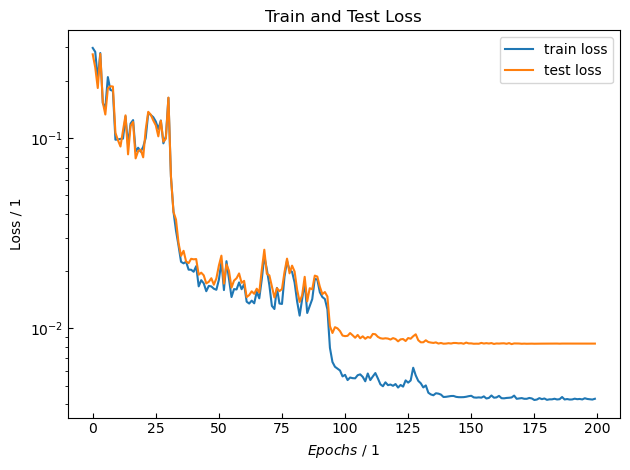

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Exportieren der Lernkurven zur Auswertung

In [11]:
np.savez('data/models/hyperparams/loss_005_002.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999080219413653 , R^2(NH3) = 0.999906615401528
Test Dataset: R^2(H2) = 0.9998725484096843 , R^2(NH3) = 0.9997199866788519
Max Error Training: |x_H2 - x_H2,pred| = 0.03936741146707562 , |x_NH3 - x_NH3,pred| = 0.011879086196932648
Max Error Test: |x_H2 - x_H2,pred| = 0.008211321095506263 , |x_NH3 - x_NH3,pred| = 0.012704653904730356


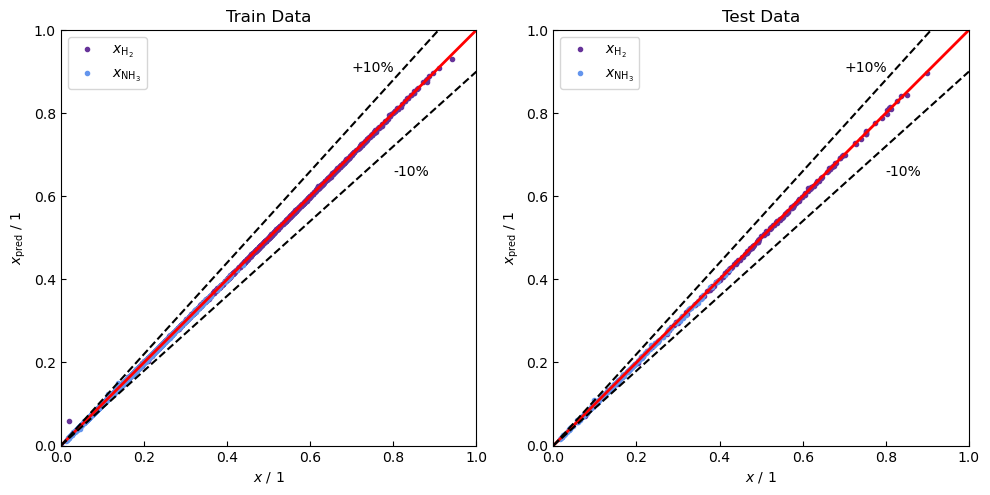

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

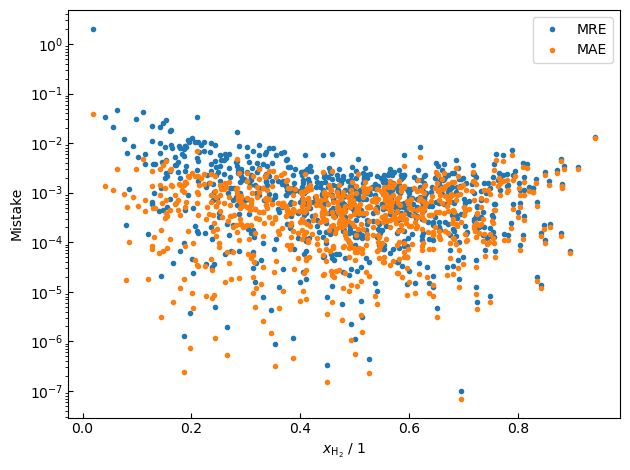

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

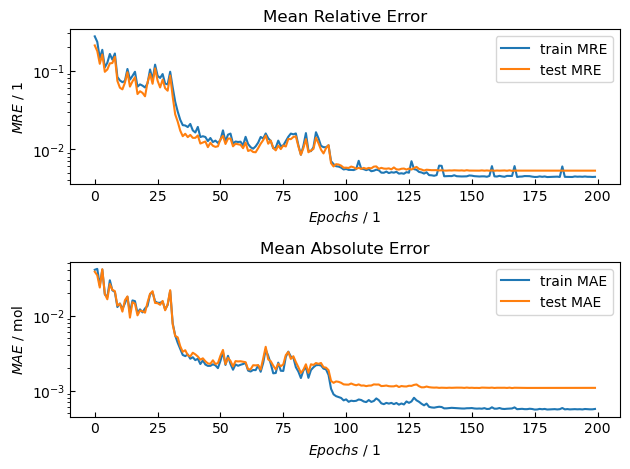

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

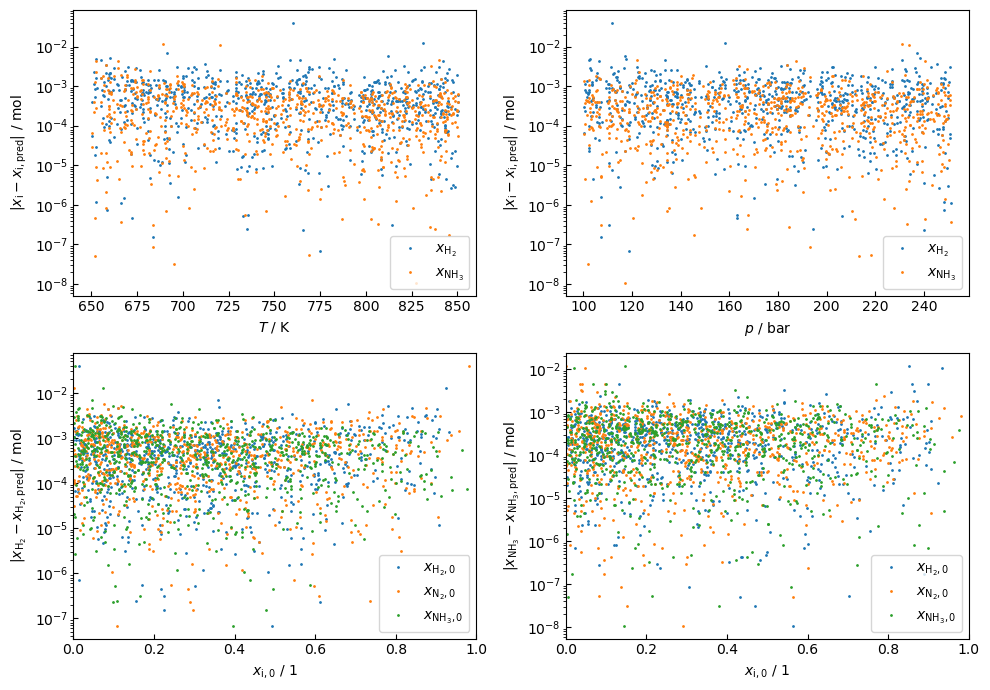

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

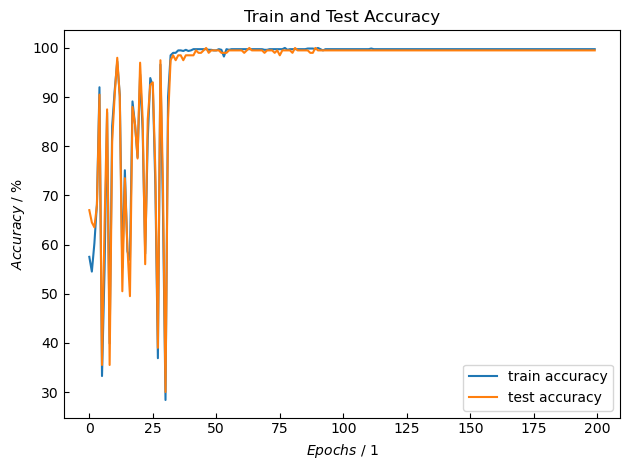

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.5234e+00,  4.7473e-01,  8.6278e-01,  5.3500e-01, -1.3935e+00],
        [ 3.2755e-01,  9.4249e-01, -1.2633e+00,  1.1408e+00,  7.3792e-02],
        [-1.7403e+00, -2.0467e-01, -7.5283e-01, -5.4417e-01,  1.2950e+00],
        [-2.9497e-01,  1.0435e+00, -5.4533e-01, -5.3151e-01,  1.0784e+00],
        [-6.5378e-01, -1.4846e-01,  1.2918e+00, -1.3779e+00,  1.4056e-01],
        [ 7.1847e-01,  6.7268e-01,  4.2490e-02, -1.2499e+00,  1.2358e+00],
        [-7.3694e-01, -5.5658e-01,  3.4696e-01, -8.3931e-01,  5.1734e-01],
        [-6.4356e-01,  1.1055e+00,  4.1843e-01,  2.2344e-01, -6.3901e-01],
        [ 9.5982e-03, -2.4183e-01,  7.4297e-01,  1.3177e-01, -8.6382e-01],
        [-8.9649e-02, -5.0450e-01, -6.9228e-01,  4.9430e-01,  1.7418e-01],
        [-2.4813e-01,  1.0058e+00, -6.1781e-01, -1.2717e+00,  1.9061e+00],
        [ 2.9746e-01,  1.5856e+00,  6.3583e-01, -3.6344e-01, -2.5253e-01],
        [ 1.5547e+00,  1.3097e+00, -3.1481e-01,  1.4720e+00, -1.1955e+00],
        [ 1.3474e+00,  1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.1048,  0.1592, -0.2381,  0.0550, -0.1831],
         [-0.0735, -0.0849,  0.3034, -0.2310, -0.2526],
         [ 0.1374,  0.0762,  0.1536, -0.1454,  0.2229],
         [ 0.0785,  0.0253, -0.0352, -0.2824, -0.2286],
         [-0.3423,  0.1504,  0.3684, -0.1284,  0.0815],
         [-0.3659,  0.0381, -0.4558, -0.1469, -0.3393],
         [ 0.1575, -0.1138, -0.0923, -0.2691, -0.2640],
         [-0.3819, -0.1734, -0.3135,  0.3384, -0.1008],
         [-0.1697,  0.0639, -0.1559,  0.3182, -0.0939],
         [-0.0801,  0.0349, -0.2568,  0.1415, -0.2114],
         [ 0.0222,  0.0010, -0.2138, -0.3406, -0.2598],
         [ 0.1254, -0.1325,  0.0237, -0.3941, -0.2660],
         [ 0.1438, -0.3987,  0.1674,  0.3953,  0.2296],
         [ 0.4217, -0.2322, -0.2702,  0.0096, -0.2626],
         [ 0.1808, -0.2415,  0.1411,  0.3151, -0.1040],
         [ 0.0888,  0.0388, -0.0679, -0.2451,  0.1372],
         [-0.4161, -0.2010, -0.0248,  0.3177,  0.2953],
         [ 0.0177,  0.160

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7571, 0.4322, 0.3070, 0.2517, 0.1635],
        [0.2577, 0.1304, 0.5685, 0.3736, 0.1467]])
tensor([[ 0.1667, -0.3501],
        [ 0.0663, -0.0737]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 4.7153e-02, -9.8757e-01, -1.3713e+00,  1.8218e+00, -5.1619e-01],
        [ 1.0114e+00,  8.0564e-01,  6.3309e-01,  4.3238e-01, -1.0632e+00],
        [ 8.8372e-01,  1.0953e+00,  4.3870e-02, -1.2372e+00,  1.2215e+00],
        [-3.5438e-01, -1.0930e+00, -9.2695e-01, -9.1550e-01,  1.8454e+00],
        [-2.1667e-01, -8.4584e-01, -5.2488e-01,  1.3602e+00, -8.7514e-01],
        [-7.1468e-01, -1.2815e+00,  2.0716e+00, -9.3383e-01, -1.0786e+00],
        [-2.1370e-01,  1.1564e+00, -1.2154e+00, -2.8136e-01,  1.4803e+00],
        [ 1.4624e+00,  1.6055e+00, -3.4240e-01,  9.2615e-01, -6.1056e-01],
        [-2.4182e-01,  5.0711e-01,  6.6396e-01, -7.4927e-01,  1.1421e-01],
        [-1.6567e+00,  3.3916e-01, -2.7547e-02,  9.2913e-02, -6.7929e-02],
        [-1.7457e+00,  1.6628e+00, -4.5099e-02,  3.5279e-01, -3.1632e-01],
        [ 1.5672e+00, -1.6738e+00, -1.0385e+00, -7.6221e-01,  1.7982e+00],
        [-6.8468e-02, -1.0068e+00, -8.0976e-01, -5.4473e-01,  1.3514e+00],
        [ 9.8009e-01,  6.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()